# Sentiment Analysis

In [1]:
!pip install datasets

     |████████████████████████████████| 510 kB 3.4 MB/s            
     |████████████████████████████████| 38.3 MB 89.9 MB/s            
     |████████████████████████████████| 193 kB 32.8 MB/s            
     |████████████████████████████████| 346 kB 86.5 MB/s            
     |████████████████████████████████| 170 kB 94.4 MB/s            
     |████████████████████████████████| 133 kB 88.9 MB/s            
     |████████████████████████████████| 116 kB 86.1 MB/s            
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2021.11.1
    Uninstalling fsspec-2021.11.1:
      Successfully uninstalled fsspec-2021.11.1
  Attempting uninstall: dill
    Found existing installation: dill 0.3.4
    Uninstalling dill-0.3.4:
      Successfully uninstalled dill-0.3.4


In [2]:
!pip install transformers

     |████████████████████████████████| 8.5 MB 3.4 MB/s            
     |████████████████████████████████| 1.3 MB 31.9 MB/s            
     |████████████████████████████████| 773 kB 91.9 MB/s            
     |████████████████████████████████| 3.6 MB 27.0 MB/s            


## Loading Classifier

In [3]:
import torch
from transformers import pipeline
import pandas as pd
import torch
import datasets
from datasets import Dataset
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

def get_model(model_name):
    if torch.cuda.is_available():
        print('Using GPU...')
        classifier = pipeline("text-classification", model=model_name, device=0, )
    else:
        print('Using CPU...')
        classifier = pipeline("text-classification", model=model_name, device=-1)
    return classifier

In [15]:
classifier = get_model("zhayunduo/roberta-base-stocktwits-finetuned")

Using GPU...


In [16]:
classifier("NVDA holding gem_stone chart_increasing")

[{'label': 'Positive', 'score': 0.9985865354537964}]

In [17]:
classifier = get_model("ProsusAI/Finbert")

Using GPU...


In [18]:
classifier("NVDA shoots through the horizontal resistance of 13.11 and next resistance shall be 13.78")

[{'label': 'neutral', 'score': 0.9257917404174805}]

In [9]:
def save_labels(df, output, filename):
    positive_scores = []
    negative_scores = []
    neutral_scores = []
    scores = {
        'positive': [],
        'negative': [],
        'neutral': []
    }
    final_labels = []
    for labels in output:
        for i in range(len(labels)):
            scores[labels[i]['label'].lower()].append(labels[i]['score'])
        if labels[0]['label'] == 'neutral':
            final_labels.append(labels[1]['label'].lower())
        else:
            final_labels.append(labels[0]['label'].lower())

    df["positive"] = scores['positive']
    df["negative"] = scores['negative']
    if len(scores['neutral']) > 0:
        df["neutral"] = scores['neutral']
    df["label"] = final_labels

    df.to_csv(filename, index=False)

## Analyzing News Headlines

In [3]:
## Loading csv
news_df = pd.read_csv('nvda_news_headlines.csv')

In [ ]:
## Getting sentiments
news_output = classifier(news_df["title"].tolist(), top_k=None)

In [29]:
## Saving to csv
save_labels(news_df, news_output, "nvda_news_sentiment.csv")

## Analyzing StockTwits

In [32]:
## Loading csv
stocktwits_df = pd.read_csv('nvda_stocktwits.csv')
stocktwits_dataset = Dataset.from_pandas(stocktwits_df)

In [62]:
## Getting sentiments
stocktwits_output = []
for out in tqdm(classifier(KeyDataset(stocktwits_dataset, " text"), batch_size=32, top_k=None, truncation=True), total=len(stocktwits_dataset)):
    stocktwits_output.append(out)

In [27]:
## Saving to csv
save_labels(stocktwits_df, stocktwits_output, "nvda_stocktwits_sentiment.csv")

## Testing Sentiment Accuracy for StockTwits

In [31]:

user_labeled = pd.read_csv('nvda_stocktwits_final.csv')
bert_labeled = pd.read_csv('nvda_stocktwits_sentiment.csv')


In [30]:
sampled_user_labeled = user_labeled[user_labeled['label'].isin(['negative', 'positive'])]
sampled_user_labeled = sampled_user_labeled.sample(n=10000)
sampled_user_labeled.to_csv("nvda_sampled_user_labeled.csv", index=False)

In [3]:

def compute_accuracy(actual_df, predicted_df):
    correct_predictions = (actual_df['label'] == predicted_df['label']).sum()
    total_samples = len(actual_df)
    accuracy = correct_predictions / total_samples
    return accuracy


In [8]:
finbert = get_model("ProsusAI/Finbert")

Using GPU...


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [9]:
# testing finbert
user_labeled = []
sampled_user_labeled = pd.read_csv('nvda_sampled_user_labeled.csv')
sampled_user_labeled_dataset = Dataset.from_pandas(sampled_user_labeled)
for out in tqdm(finbert(KeyDataset(sampled_user_labeled_dataset, "text"), batch_size=32, top_k=None, truncation=True), total=len(sampled_user_labeled_dataset)):
    user_labeled.append(out)
save_labels(sampled_user_labeled, user_labeled, "nvda_sampled_stocktwits_sentiment.csv")

  0%|          | 0/10000 [00:00<?, ?it/s]

[{'label': 'neutral', 'score': 0.9510737061500549}, {'label': 'negative', 'score': 0.029156435281038284}, {'label': 'positive', 'score': 0.01976984180510044}]


In [15]:
actual = pd.read_csv('nvda_sampled_user_labeled.csv')
predicted = pd.read_csv("nvda_sampled_stocktwits_sentiment.csv")
print(compute_accuracy(actual, predicted))

0.1507


In [7]:
models = [
    {
        "model_name": "ProsusAI/Finbert",
        "short_name": "prosusai_finbert"
    },
    {
        "model_name": "cardiffnlp/twitter-roberta-base-sentiment-latest",
        "short_name": "twitter-roberta"
    },
    {
        "model_name": "zhayunduo/roberta-base-stocktwits-finetuned", 
        "short_name": "roberta-stocktwits"
    },
    {
        "model_name": "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis",
        "short_name": "distilroberta-financial-news"
    },
]

def make_predictions(model, src, dst):
    user_labeled = []
    sampled_user_labeled = pd.read_csv(src)
    sampled_user_labeled_dataset = Dataset.from_pandas(sampled_user_labeled)
    for out in tqdm(model(KeyDataset(sampled_user_labeled_dataset, "text"), batch_size=32, top_k=None, truncation=True), total=len(sampled_user_labeled_dataset)):
        user_labeled.append(out)
    save_labels(sampled_user_labeled, user_labeled, dst)

    
def calc_accuracies(models):
    accuracies = []
    categories = []
    for model_info in models:
        model = get_model(model_info["model_name"])
        print(f"Starting {model_info['short_name']}...")
        make_predictions(model, 'nvda_sampled_user_labeled.csv', f"nvda_{model_info['short_name']}_sentiment.csv")
        actual = pd.read_csv('nvda_sampled_user_labeled.csv')
        predicted = pd.read_csv(f"nvda_{model_info['short_name']}_sentiment.csv")
        acc = compute_accuracy(actual, predicted)
        accuracies.append(acc)
        categories.append(model_info['short_name'])
        print(f"{model_info['short_name']} acc: {acc}")
        del model
        torch.cuda.empty_cache()
    plt.bar(categories, accuracies)
    plt.xlabel("Model")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy Bar Chart")
    plt.tight_layout()
    plt.show()    
        

Using GPU...
Starting roberta-stocktwits...


  0%|          | 0/10000 [00:00<?, ?it/s]

roberta-stocktwits acc: 0.9092
Using GPU...
Starting distilroberta-financial-news...


  0%|          | 0/10000 [00:00<?, ?it/s]

distilroberta-financial-news acc: 0.5766


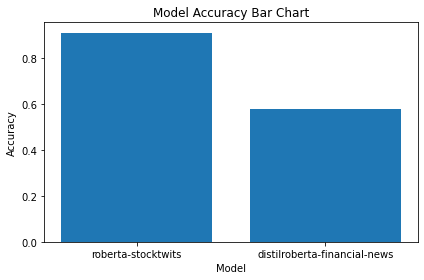

In [10]:
calc_accuracies(models)

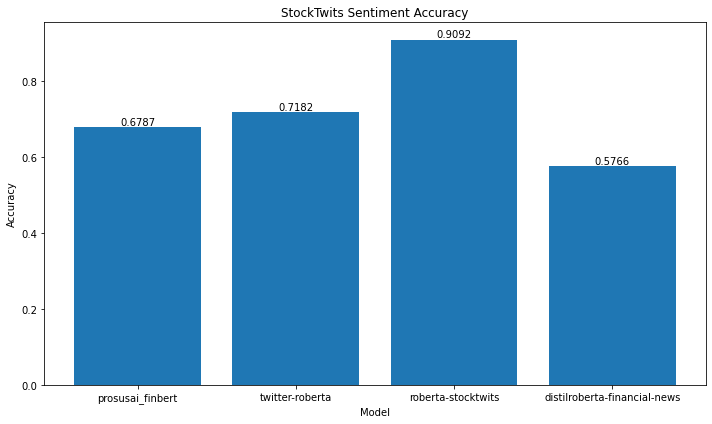

In [19]:
accuracies = [0.6787, 0.7182, 0.9092, 0.5766]
categories = ["prosusai_finbert", "twitter-roberta", "roberta-stocktwits", "distilroberta-financial-news"]
plt.figure(figsize=(10, 6)) 
bars = plt.bar(categories, accuracies)
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{acc:.4f}', ha='center', va='bottom')
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("StockTwits Sentiment Accuracy")
plt.tight_layout()
plt.savefig("stocktwits-barchart.png")
plt.show() 